필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

In [3]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.preprocessing import StandardScaler

데이터 가져오기

In [5]:
base_path = r"C:\Users\owner\Desktop\water-source\data"

In [6]:
jsb_yearly = pd.read_excel(base_path+"\Jugsanbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [7]:
print(type(jsb_yearly))  # type-dict
print(jsb_yearly.keys())  # 2012년부터 2022년까지

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])


In [8]:
jsb_yearly['2012년'].columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

2013년 자료부터

In [9]:
jsb_yearly_df13 = pd.DataFrame()

for item in list(jsb_yearly.keys())[1:]:
    jsb_yearly_df13 = pd.concat([jsb_yearly_df13, jsb_yearly[item]])

In [10]:
jsb_yearly_df13 = jsb_yearly_df13.reset_index(drop=True)

결측치 확인

In [11]:
jsb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82064 entries, 0 to 82063
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
dtypes: float64(9), object(2)
memory usage: 6.9+ MB


In [12]:
jsb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
수소이온농도          9972
전기전도도 μS/cm     9925
용존산소 mg/L      11066
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
dtype: int64

In [13]:
jsb_yearly_df13.head()

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00h,나주,3.3,6.8,272.0,12.0,1.8,1.9,NaN,NaN,12.2
1,2013-01-01 01h,나주,3.1,6.7,272.0,12.0,1.7,1.9,NaN,NaN,12.0
2,2013-01-01 02h,나주,3.0,6.7,273.0,12.0,1.7,1.9,NaN,NaN,12.1
3,2013-01-01 03h,나주,3.0,6.7,275.0,12.0,1.6,1.9,NaN,NaN,12.2
4,2013-01-01 04h,나주,2.9,6.7,276.0,12.0,1.5,1.9,NaN,NaN,12.1


유량 데이터 추가하기

In [14]:
jsb_flow_yearly = pd.read_excel(base_path+"\Jugsanbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [15]:
for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly[year]['연월일시'] = jsb_flow_yearly[year]['시간'].apply(lambda x : x[:-3])

In [16]:
jsb_flow_yearly_hour = {}

for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly[year].groupby('연월일시').mean()

In [17]:
for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly_hour[year].reset_index()

In [18]:
jsb_flow_yearly_hour_df = pd.DataFrame()

for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour_df = pd.concat([jsb_flow_yearly_hour_df, jsb_flow_yearly_hour[year]])

In [19]:
jsb_flow_yearly_hour_df = jsb_flow_yearly_hour_df.reset_index(drop=True)

In [20]:
print(jsb_flow_yearly_hour_df.__len__())
print(jsb_yearly_df13.__len__())

84462
82064


In [21]:
jsb_yearly_df13['연월일시'] = jsb_yearly_df13['측정일/월'].transform(lambda x: x.strip('h').replace('-', '.'))

In [22]:
jsb_data = pd.merge(jsb_yearly_df13, jsb_flow_yearly_hour_df, how='outer')

In [23]:
jsb_data = jsb_data[:82064]

In [24]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12   상류수위(EL.m)  82051 non-null  float64
 13   하류수위(EL.m)  82051 non-null  float64
 14   유입량(㎥/s)    82051 non-null  float64
 15   방류량(㎥/s)    82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [25]:
jsb_data.columns = [x.strip() for x in list(jsb_data.columns)]

In [26]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12  상류수위(EL.m)   82051 non-null  float64
 13  하류수위(EL.m)   82051 non-null  float64
 14  유입량(㎥/s)     82051 non-null  float64
 15  방류량(㎥/s)     82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [27]:
jsb_data = jsb_data.loc[:, list(jsb_data.columns)[:3]  + list(jsb_data.columns)[4:5] + list(jsb_data.columns)[6:-5] + list(jsb_data.columns)[-4:-3] + list(jsb_data.columns)[-1:]]

In [28]:
jsb_data.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [29]:
jsb_data.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
전기전도도 μS/cm     9925
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
상류수위(EL.m)        13
방류량(㎥/s)          13
dtype: int64

In [30]:
jsb_data.isnull().sum() /len(jsb_data)

측정일/월          0.000000
측정소명           0.000000
수온 ℃           0.123184
전기전도도 μS/cm    0.120942
탁도 NTU         0.131020
총유기탄소 mg/L     0.195128
총질소 mg/L       0.182053
총인 mg/L        0.174157
클로로필-a mg/㎥    0.151357
상류수위(EL.m)     0.000158
방류량(㎥/s)       0.000158
dtype: float64

In [31]:
len(jsb_data)

82064

시간데이터 추가

In [32]:
jsb_df = jsb_data.copy()

In [33]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [34]:
col_c = list(jsb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [35]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '전기전도도 μS/cm',
 '탁도 NTU',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [36]:
for i in range(1, 49):
    jsb_df[str(i) + 'shift 탁도'] = jsb_df['탁도 NTU'].shift(i)

In [37]:
len(jsb_df)

82064

In [38]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)',
       '1shift 탁도', '2shift 탁도', '3shift 탁도', '4shift 탁도', '5shift 탁도',
       '6shift 탁도', '7shift 탁도', '8shift 탁도', '9shift 탁도', '10shift 탁도',
       '11shift 탁도', '12shift 탁도', '13shift 탁도', '14shift 탁도', '15shift 탁도',
       '16shift 탁도', '17shift 탁도', '18shift 탁도', '19shift 탁도', '20shift 탁도',
       '21shift 탁도', '22shift 탁도', '23shift 탁도', '24shift 탁도', '25shift 탁도',
       '26shift 탁도', '27shift 탁도', '28shift 탁도', '29shift 탁도', '30shift 탁도',
       '31shift 탁도', '32shift 탁도', '33shift 탁도', '34shift 탁도', '35shift 탁도',
       '36shift 탁도', '37shift 탁도', '38shift 탁도', '39shift 탁도', '40shift 탁도',
       '41shift 탁도', '42shift 탁도', '43shift 탁도', '44shift 탁도', '45shift 탁도',
       '46shift 탁도', '47shift 탁도', '48shift 탁도'],
      dtype='object')

In [39]:
len(jsb_df)

82064

결측치 보간법

In [40]:
from datetime import datetime

In [41]:
jsb_df = jsb_df.copy()

In [42]:
jsb_df['측정일/월'] = jsb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [43]:
jsb_df = jsb_df.copy().set_index('측정일/월').interpolate(method='time')

In [44]:
jsb_df = jsb_df.dropna()

In [45]:
jsb_df.__len__()

79963

In [46]:
jsb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 탁도',
       '2shift 탁도', '3shift 탁도', '4shift 탁도', '5shift 탁도', '6shift 탁도',
       '7shift 탁도', '8shift 탁도', '9shift 탁도', '10shift 탁도', '11shift 탁도',
       '12shift 탁도', '13shift 탁도', '14shift 탁도', '15shift 탁도', '16shift 탁도',
       '17shift 탁도', '18shift 탁도', '19shift 탁도', '20shift 탁도', '21shift 탁도',
       '22shift 탁도', '23shift 탁도', '24shift 탁도', '25shift 탁도', '26shift 탁도',
       '27shift 탁도', '28shift 탁도', '29shift 탁도', '30shift 탁도', '31shift 탁도',
       '32shift 탁도', '33shift 탁도', '34shift 탁도', '35shift 탁도', '36shift 탁도',
       '37shift 탁도', '38shift 탁도', '39shift 탁도', '40shift 탁도', '41shift 탁도',
       '42shift 탁도', '43shift 탁도', '44shift 탁도', '45shift 탁도', '46shift 탁도',
       '47shift 탁도', '48shift 탁도'],
      dtype='object')

In [47]:
col = list(jsb_df.columns[2:])
print(col)

['전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 탁도', '2shift 탁도', '3shift 탁도', '4shift 탁도', '5shift 탁도', '6shift 탁도', '7shift 탁도', '8shift 탁도', '9shift 탁도', '10shift 탁도', '11shift 탁도', '12shift 탁도', '13shift 탁도', '14shift 탁도', '15shift 탁도', '16shift 탁도', '17shift 탁도', '18shift 탁도', '19shift 탁도', '20shift 탁도', '21shift 탁도', '22shift 탁도', '23shift 탁도', '24shift 탁도', '25shift 탁도', '26shift 탁도', '27shift 탁도', '28shift 탁도', '29shift 탁도', '30shift 탁도', '31shift 탁도', '32shift 탁도', '33shift 탁도', '34shift 탁도', '35shift 탁도', '36shift 탁도', '37shift 탁도', '38shift 탁도', '39shift 탁도', '40shift 탁도', '41shift 탁도', '42shift 탁도', '43shift 탁도', '44shift 탁도', '45shift 탁도', '46shift 탁도', '47shift 탁도', '48shift 탁도']


In [48]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
print(col_v)

['전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 탁도', '2shift 탁도', '3shift 탁도', '4shift 탁도', '5shift 탁도', '6shift 탁도', '7shift 탁도', '8shift 탁도', '9shift 탁도', '10shift 탁도', '11shift 탁도', '12shift 탁도', '13shift 탁도', '14shift 탁도', '15shift 탁도', '16shift 탁도', '17shift 탁도', '18shift 탁도', '19shift 탁도', '20shift 탁도', '21shift 탁도', '22shift 탁도', '23shift 탁도', '24shift 탁도', '25shift 탁도', '26shift 탁도', '27shift 탁도', '28shift 탁도', '29shift 탁도', '30shift 탁도', '31shift 탁도', '32shift 탁도', '33shift 탁도', '34shift 탁도', '35shift 탁도', '36shift 탁도', '37shift 탁도', '38shift 탁도', '39shift 탁도', '40shift 탁도', '41shift 탁도', '42shift 탁도', '43shift 탁도', '44shift 탁도', '45shift 탁도', '46shift 탁도', '47shift 탁도', '48shift 탁도']


피처 정규화 없이

In [49]:
X_train, X_test, y_train, y_test = train_test_split(jsb_df.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [50]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3)

In [51]:
gb_grid.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [52]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [53]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.933997,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.932844,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.930881,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.917952,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.909187,5


In [54]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [55]:
estimator = gb_grid.best_estimator_

In [56]:
pred = estimator.predict(X_test)

In [57]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.16 전기전도도 μS/cm
0.05 탁도 NTU
0.19 총유기탄소 mg/L
0.16 총질소 mg/L
0.1 총인 mg/L
0.13 상류수위(EL.m)
0.05 방류량(㎥/s)
0.01 1shift 탁도
0.0 2shift 탁도
0.01 3shift 탁도
0.01 4shift 탁도
0.0 5shift 탁도
0.0 6shift 탁도
0.0 7shift 탁도
0.0 8shift 탁도
0.0 9shift 탁도
0.01 10shift 탁도
0.0 11shift 탁도
0.0 12shift 탁도
0.0 13shift 탁도
0.0 14shift 탁도
0.0 15shift 탁도
0.0 16shift 탁도
0.0 17shift 탁도
0.0 18shift 탁도
0.0 19shift 탁도
0.0 20shift 탁도
0.0 21shift 탁도
0.0 22shift 탁도
0.01 23shift 탁도
0.0 24shift 탁도
0.0 25shift 탁도
0.0 26shift 탁도
0.0 27shift 탁도
0.0 28shift 탁도
0.0 29shift 탁도
0.0 30shift 탁도
0.0 31shift 탁도
0.0 32shift 탁도
0.0 33shift 탁도
0.0 34shift 탁도
0.0 35shift 탁도
0.0 36shift 탁도
0.0 37shift 탁도
0.0 38shift 탁도
0.0 39shift 탁도
0.0 40shift 탁도
0.0 41shift 탁도
0.0 42shift 탁도
0.0 43shift 탁도
0.0 44shift 탁도
0.0 45shift 탁도
0.0 46shift 탁도
0.01 47shift 탁도
0.01 48shift 탁도


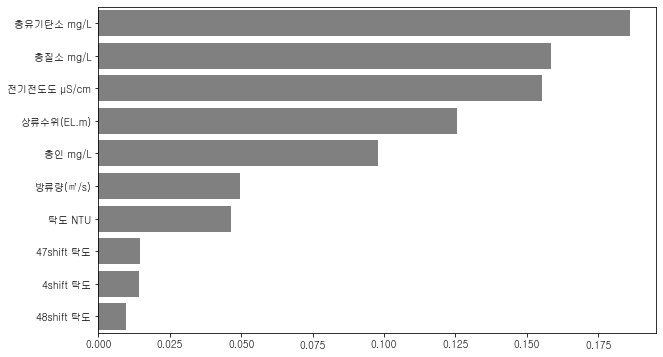

In [58]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [59]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.9554599880358301


In [60]:
feature_series[:10]

총유기탄소 mg/L     0.185970
총질소 mg/L       0.158418
전기전도도 μS/cm    0.155179
상류수위(EL.m)     0.125422
총인 mg/L        0.097800
방류량(㎥/s)       0.049752
탁도 NTU         0.046527
47shift 탁도     0.014524
4shift 탁도      0.014422
48shift 탁도     0.009644
dtype: float64

피처 정규화

In [61]:
scaler = StandardScaler()
scaler.fit(jsb_df.loc[:, col_v])
jsb_scaled = scaler.transform(jsb_df.loc[:, col_v])

jsb_df_scaled = pd.DataFrame(data = jsb_scaled, columns = col_v)

In [62]:
jsb_df_scaled.head()

,전기전도도 μS/cm,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),1shift 탁도,2shift 탁도,3shift 탁도,...,39shift 탁도,40shift 탁도,41shift 탁도,42shift 탁도,43shift 탁도,44shift 탁도,45shift 탁도,46shift 탁도,47shift 탁도,48shift 탁도
0,-1.198346,0.044874,-0.355037,-0.555441,1.071211,0.526046,-0.277792,0.047844,0.050783,0.021190,...,-0.150392,-0.138555,-0.132636,-0.132635,-0.114880,-0.114878,-0.168144,-0.174061,-0.174058,-0.156298
1,-1.187208,0.062630,-0.355037,-0.518827,1.131865,0.552987,-0.277792,0.044885,0.047823,0.050783,...,-0.162230,-0.150392,-0.138555,-0.132635,-0.132637,-0.114878,-0.114876,-0.168142,-0.174058,-0.174054
2,-1.198346,0.074467,-0.355037,-0.530421,1.192519,0.552987,-0.277792,0.062641,0.044864,0.047824,...,-0.168148,-0.162230,-0.150392,-0.138554,-0.132637,-0.132635,-0.114876,-0.114873,-0.168140,-0.174054
3,-1.198346,0.098142,-0.254360,-0.513335,1.172301,0.571845,-0.277792,0.074479,0.062620,0.044865,...,-0.174067,-0.168148,-0.162230,-0.150391,-0.138555,-0.132635,-0.132632,-0.114873,-0.114871,-0.168135
4,-1.187208,0.157330,-0.254360,-0.480383,1.192519,0.577233,-0.277792,0.098154,0.074458,0.062621,...,-0.179986,-0.174067,-0.168148,-0.162229,-0.150393,-0.138553,-0.132632,-0.132630,-0.114871,-0.114867


In [63]:
X_trains, X_tests, y_trains, y_tests = train_test_split(jsb_df_scaled.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [64]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3)

In [65]:
gb_grids.fit(X_trains, np.log1p(y_trains))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [66]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [67]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.934132,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.932921,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.931035,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.918026,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.909287,5


In [68]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [69]:
estimators = gb_grids.best_estimator_

In [70]:
preds = estimators.predict(X_tests)

In [71]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.16 전기전도도 μS/cm
0.05 탁도 NTU
0.19 총유기탄소 mg/L
0.16 총질소 mg/L
0.1 총인 mg/L
0.13 상류수위(EL.m)
0.05 방류량(㎥/s)
0.01 1shift 탁도
0.0 2shift 탁도
0.01 3shift 탁도
0.01 4shift 탁도
0.0 5shift 탁도
0.0 6shift 탁도
0.0 7shift 탁도
0.0 8shift 탁도
0.0 9shift 탁도
0.01 10shift 탁도
0.0 11shift 탁도
0.0 12shift 탁도
0.0 13shift 탁도
0.0 14shift 탁도
0.0 15shift 탁도
0.0 16shift 탁도
0.0 17shift 탁도
0.0 18shift 탁도
0.0 19shift 탁도
0.0 20shift 탁도
0.0 21shift 탁도
0.0 22shift 탁도
0.01 23shift 탁도
0.0 24shift 탁도
0.0 25shift 탁도
0.0 26shift 탁도
0.0 27shift 탁도
0.0 28shift 탁도
0.0 29shift 탁도
0.0 30shift 탁도
0.0 31shift 탁도
0.0 32shift 탁도
0.0 33shift 탁도
0.0 34shift 탁도
0.0 35shift 탁도
0.0 36shift 탁도
0.0 37shift 탁도
0.0 38shift 탁도
0.0 39shift 탁도
0.0 40shift 탁도
0.0 41shift 탁도
0.0 42shift 탁도
0.0 43shift 탁도
0.0 44shift 탁도
0.0 45shift 탁도
0.0 46shift 탁도
0.01 47shift 탁도
0.01 48shift 탁도


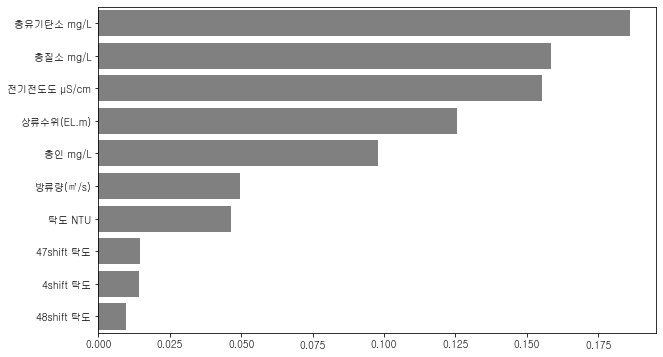

In [72]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [73]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.9555847828932804


In [74]:
feature_series[:10]

총유기탄소 mg/L     0.185970
총질소 mg/L       0.158418
전기전도도 μS/cm    0.155179
상류수위(EL.m)     0.125422
총인 mg/L        0.097800
방류량(㎥/s)       0.049752
탁도 NTU         0.046527
47shift 탁도     0.014524
4shift 탁도      0.014422
48shift 탁도     0.009644
dtype: float64